## Exercise 1 - **Computer vision** - Train a model for predicting objects in `MNIST` dataset 

### 1. Load necessary libraries and set the `device`

In [313]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch    # main lib of pytorch
from torch import nn # neural network module of pytorch
import torchmetrics # metrics module of pytorch
import mlxtend # handy library for visualizaing some special things such as confusion matrix
import torchvision # computer vision library of pytorch
from torchvision.transforms import ToTensor # import this transformer to convert our dataset to tensors

#### 1.1 Device Agnostic

In [201]:
# we prefer to use GPU if it is available, otherwise CPU is used
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 2. *Load* and *prepare* the main dataset of project using `torchvision.datasets.MNIST()` 

#### 2.1 Get `MNIST` dataset through downloading, then some args should be passed to`torchvision.datasets.MNIST()`which are explained as below:
* `train=True`: True if we need a training set, otherwise we'll get a test set
* `root='data'`: We want to store our dataset in ***data*** folder located in current working directory
* `transform=ToTensor`: Our dataset should be converted to `torch.Tensor` data type, so we pass **ToTensor** class 
* `download=True`: Since our dataset does not exist, we should donwload it  
> Get more info about **MNIST** dataset: [MNIST wikipedia page](https://en.wikipedia.org/wiki/MNIST_database)


In [202]:
train_data = torchvision.datasets.MNIST(root='data',
                                        train=True,
                                        transform=ToTensor(),
                                        download=True,
)

test_data = torchvision.datasets.MNIST(root='data',
                                        train=False,
                                        download=True,
                                        transform=ToTensor(),
                                        target_transform=None
)

#### 2.2 Get shapes of our train and test

In [203]:
batch_size_of_train = train_data.data.shape[0]
batch_size_of_test = test_data.data.shape[0]
print(f'Batch size of training set: {batch_size_of_train}\nBatch size of test set: {batch_size_of_test}')

Batch size of training set: 60000
Batch size of test set: 10000


#### 2.3 Get number of labels(classes)

In [204]:
no_of_classes = len(train_data.classes)
name_of_classes = train_data.classes
class_to_idx = train_data.class_to_idx
print(f'Number of classes: {no_of_classes}\nNames of classes: \n{name_of_classes}')

Number of classes: 10
Names of classes: 
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


#### 2.4 Visualize some instances of our train dataset


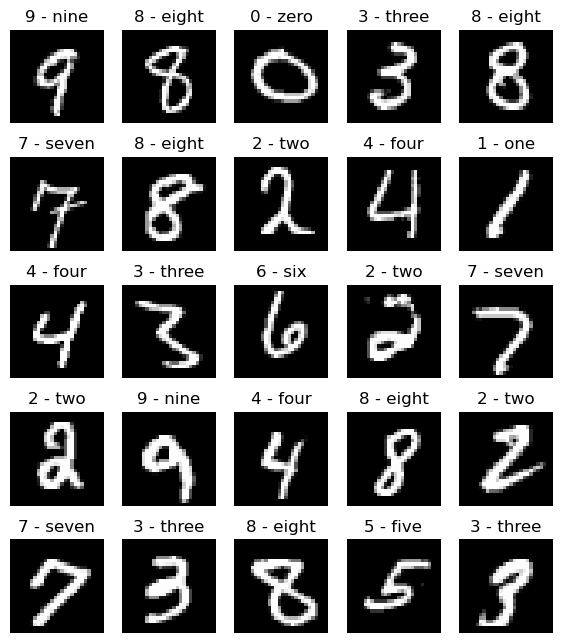

In [205]:
fig = plt.figure(figsize=(7, 8))

n_rows = 5
n_cols = 5

for i in range(1, n_rows * n_rows+1):
    fig.add_subplot(n_rows, n_cols, i)
    random_index = torch.randint(0, batch_size_of_train, size=[1]).item()
    plt.imshow(train_data[random_index][0].squeeze(dim=0), cmap='gray')
    plt.title(name_of_classes[train_data.targets[random_index]])
    plt.axis(False)

#### 2.5 Create dataloaders of train/test set for mini-batch implementation

In [206]:

# Define global batch size variable for convenience
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True
                                              )

test_dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True
                                              )

### 3. Create our neural network model - This model is inspired by TinyVGG model

**Information about this model**:  
*kernel_size* = 3 * 3  
*stride* = 1  
*padding* = 0
* Consists of 5 blocks as follows:
    * Block 1 : Convolution layer + Relu layer
    * Block 2 : Convolution layer + Relu layer + max_pool(size=2*2)
    * Block 3 : Convolution layer + Relu layer
    * Block 4 : Convolution layer + Relu layer + max_pool(size=2*2)
    * Block 5 : Flatten + Linear +  Softmax
    
Note: In the last layer, we put a `softmax` function in order to convert logits to prediction probabilities
> Get more info about **TinyVGG** model : [CNN Explainer website](https://poloclub.github.io/cnn-explainer/)


In [294]:
class MnistNeuralNetworkV0(nn.Module):
    
    def __init__(self, 
                 input_shape: int, 
                 output_shape: int, 
                 hidden_units: int=10,
                 activation_func: torch.nn.Module = 'relu'
                ):
        """ Constructor of a neural network model with this specifications in each convolutuional layer:
        kernel_size = 3 * 3  
        stride = 1  
        padding = 0

        
        We used this model to train MNIST dataset, the accuracy was acceptable.
        This model incorporates 5 blocks, each of which includes some other layers such as convolutional and ReLu layers.
        The activation function cannot be yet specified by in params, but we hope to do so soon.
        The blocks are as follows:
        
        * Block 1 : Convolution layer + Relu layer
        * Block 2 : Convolution layer + Relu layer + max_pool(size=2*2)
        * Block 3 : Convolution layer + Relu layer
        * Block 4 : Convolution layer + Relu layer + max_pool(size=2*2)
        * Block 5 : Flatten + Linear +  Softmax
        
        Note: The linear layer in the last block is to convert all the numbers taken from the flatten layer to output shape
        Note: In the last layer, we put a softmax function in order to convert logits to prediction probabilities
        > Get more info about **TinyVGG** model : [CNN Explainer website](https://poloclub.github.io/cnn-explainer/)


        Args:
            input_shape (int): Color channels of the input, 1 for gray scale , and 3 for RGB
            output_shape (int): The number of class labels. For instance if your dataset includes handwritten numbers, the number of class labels is 10 (0-9)
            hidden_units (int, optional): _description_. Defaults to 10.
            activation_func (torch.nn.Module, optional): _description_. Defaults to 'relu'. It will upgraded soon! Other ones such as Tanh will be added!
        """
        super().__init__()

        self.first_block = nn.Sequential(nn.Conv2d(in_channels=input_shape,
                                     out_channels=hidden_units,
                                     kernel_size=3,
                                     stride=1),
                                     nn.ReLU())

        self.second_block = nn.Sequential(nn.Conv2d(in_channels=hidden_units,
                                     out_channels=hidden_units,
                                     kernel_size=3,
                                     stride=1),
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2))

        self.third_block = nn.Sequential(nn.Conv2d(in_channels=hidden_units,
                                     out_channels=hidden_units,
                                     kernel_size=3,
                                     stride=1),
                                     nn.ReLU())

        self.fourth_block = nn.Sequential(nn.Conv2d(in_channels=hidden_units,
                                     out_channels=hidden_units,
                                     kernel_size=3,
                                     stride=1),
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2))

        self.fifth_block = nn.Sequential(nn.Flatten(),
                                         nn.Linear(in_features=hidden_units*4*4,
                                                   out_features=output_shape))
                                         
    def forward(self, x:torch.Tensor, label_prediction=False) -> torch.Tensor :
        """Perform forward propagation

        Args:
            x (torch.Tensor): Input dataset without true labels
            label_prediction (bool, optional): _description_. Defaults to False. If true, the ouput will
            be the predicted labels of each instance. If false, prediction probability of each label will be the case.
            Shapes of output:
            True : (Number of batches * 1)
            False: (Number of batches * Number of class labels)

        Returns:
            torch.Tensor: A torch tensor of the output of our neural network
        """
        x = self.first_block(x)
        x = self.second_block(x)
        x = self.third_block(x)
        x = self.fourth_block(x)
        x = self.fifth_block(x)
        if label_prediction:
            return x.argmax(dim=1)
        else:
            return x

#### 5.1 - Create an object of `MnistNeuralNetworkV0` ( instantiation ), and set it to use `GPU` for higher speed

In [349]:
input_shape = 1    # Since our data is gray scale, we have just 1 color channel
output_shape = 10  # the number of class labels is from 0-9 ( 10 )
hidden_units = 10  # we set this to 10, according to the architecture of TineVGG model, but you can change it in order to get better accuracy 


# Instantiate an object from the model
model_0 = MnistNeuralNetworkV0(input_shape=input_shape, output_shape=output_shape, hidden_units=hidden_units)

# Set the device of our model to 'device' variable which we set before ( GPU or CPU )
model_0.to(device)


MnistNeuralNetworkV0(
  (first_block): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (second_block): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (third_block): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (fourth_block): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fifth_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=10, bias=True)
  )
)

### 4. Define **cost function** and **optimizer** 
#### 4.1 - We choose to use `Cross Entropy` cost function whereby we can calculate the differences between the predicitions of our model and true labels
>Note: For more info about **Cross Entropy**: [Cross Entrpy tutorial](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e)
#### 4.2 - Regarding an optimizer, we consider `Stochastic Gradient Descent`, this optimizer performs gradient descent on weights with the gradients    calculated through `Back Propagation`
>Note: For more info about **Stochastic gradient descent**: [Stochastic gradient descent](https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31)

In [353]:
# Define cross entropy loss function
loss_fn = nn.CrossEntropyLoss()

# Define an optimizer, necessary params are passed 
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.05)   # lr: Learning rate of gradient descent

### 5. Train our model using `Gradient Descent`
* Define accuracy function
* Do **forward propagation** with the random weights specified in the model automatically when we create an object of the model
* The **loss function** then is used to calculate the cost between our predictions and the real ones

In [328]:
def calculate_accuracy(y_pred:torch.Tensor,
             y_true:torch.Tensor) -> float:
    
    
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

    
    

In [329]:
def train_model(model:nn.Module,
                training_set_dataloader: torch.utils.data.DataLoader,
                optmizer: torch.optim,
                loss_function: torch.nn,
                epochs: int=10) -> None:
    """
    This function is aimed at training a model with any training set.( Note: Training set dimensions should be consistent with the model specifications)
    The cost function is the difference between the predictions of our hypothesis model and true labels. The aim is to minimize it so as to find
    the best weights to fit our data.
    The process of minimizing the cost function involves different optimization objects which can be passed to this function. For example Gradient Descent
    is one of them that you can use torch.optmis module to create an object for it.
    
    NOTE:
    This function needs dataloader, not a whole tensor of your instances and labels. In other words, for better memory efficiency your training set 
    should be split into batches which can be done througth dataloaders in pytorch. (nn.utils.data.DataLoader)
    
    
    
    
    
    Args:
            model (nn.Module): An object created from classes which inherits from nn.Module class, this is our hypothesis model 
            training_set (torch.utils.data.dataloader): A dataloader incorporates batches, each of which inculdes some instances of our training dataset
            optimizer (nn.optims): An optimizer object for minimizing the cost function 
            loss_function (torch.nn): A loss function object used in the optmization process
            epochs(int): How many iterations to perform gradient descent in each epoch. Defaults to 25
    
    
    
    Output:
            None
            
            There is no output when you run this function.
            
            The input model weights are modified after you run this function.
    
    """
    
    # Device agnostic for 
    no_of_batches = len(training_set_dataloader)
    for epoch in range(1, epochs+1):
        
        print(f'Epoch {epoch}\n--------------------')
        
        train_loss, train_accuracy = 0, 0
        
        for batch, (X, y) in enumerate(training_set_dataloader):
            
            # Turn on train mode of our model
            model.train()
            
            # Device agnostic for each batch
            X = X.to(device)
            y = y.to(device)
            
            # Forward propagation 
            y_logits = model.forward(X)
            y_prob_preds = torch.softmax(y_logits, dim=1)
            y_pred_labels = y_prob_preds.argmax(dim=1)
            
            # Caculate accuracy
            batch_acc = calculate_accuracy(y_pred_labels, y)
            train_accuracy += batch_acc
            
            # Cost calculation
            batch_loss = loss_function(y_logits, y)
            train_loss += batch_loss
            
            # Zero grad - if not: gradients will be accumulated 
            optimizer.zero_grad()

            # Do back propagation for getting gradients
            batch_loss.backward()


            # Do gradient descent
            optimizer.step()


        train_loss /= no_of_batches 
        train_accuracy /= no_of_batches
        print(f'Average cost of batches: {train_loss:.2f} | Average accuracy of batches: {train_accuracy:.2f} % \n')

In [354]:
train_model(model_0, train_dataloader, optmizer=optimizer, loss_function=loss_fn, epochs=5)

Epoch 1
--------------------
Average cost of batches: 0.39 | Average accuracy of batches: 86.89 % 

Epoch 2
--------------------
Average cost of batches: 0.10 | Average accuracy of batches: 96.96 % 

Epoch 3
--------------------
Average cost of batches: 0.08 | Average accuracy of batches: 97.59 % 

Epoch 4
--------------------
Average cost of batches: 0.07 | Average accuracy of batches: 97.88 % 

Epoch 5
--------------------
Average cost of batches: 0.06 | Average accuracy of batches: 98.07 % 



### 6. Evaluate our model on test set


In [324]:
def eval_model(model:nn.Module,
               test_dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               return_=False
              ):
    
    # Turn of inference mode and eval mode
    
    model.eval()
    with torch.inference_mode():
        no_of_batches = len(test_dataloader)
        no_of_instances_in_each_batch = math.floor(len(test_dataloader.dataset) / no_of_batches)
        test_acc = 0

        for batch, (X, y) in enumerate(test_dataloader):

            # Device agnostic

            X = X.to(device)
            y = y.to(device)

            # Do forward propagation
            test_logits = model.forward(X)
            test_pred_probs = test_logits.softmax(dim=1)
            test_pred_labels = test_pred_probs.argmax(dim=1)

            # Accuracy
            batch_acc = calculate_accuracy(test_pred_labels, y)
            test_acc += batch_acc



        test_acc /= no_of_batches
        if return_:
            return test_acc
        else:
            print(f'Accuracy: {test_acc:.2f}% for {no_of_batches} batches, each of which includes {no_of_instances_in_each_batch} instances' )

In [331]:
eval_model(model_0, test_dataloader, loss_fn)

Accuracy: 98.64% for 313 batches, each of which includes 31 instances


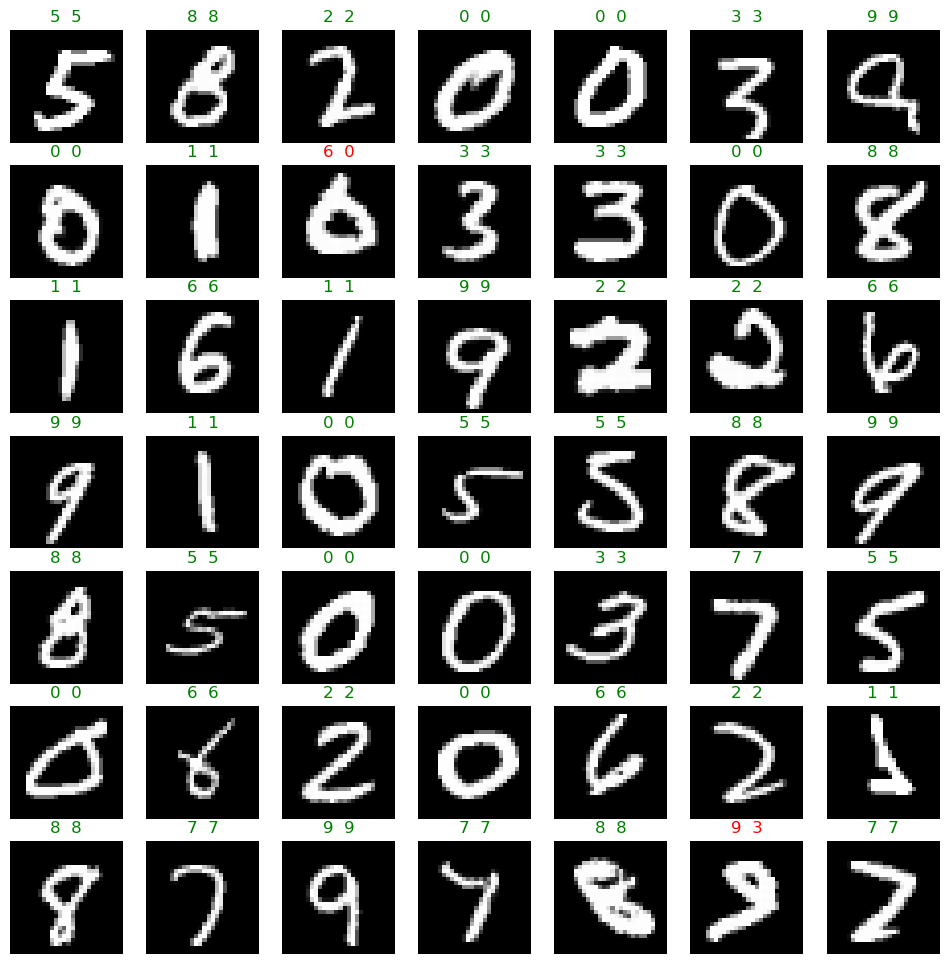

In [362]:
fig = plt.figure(figsize=(12, 12))

n_rows = 7
n_cols = 7

for i in range(1, n_rows * n_rows+1):
    fig.add_subplot(n_rows, n_cols, i)
    random_index = torch.randint(0, batch_size_of_test, size=[1]).item()
    plt.imshow(test_data[random_index][0].squeeze(dim=0), cmap='gray')
    model_0.train()
    with torch.inference_mode():
        # Do forward propagation
        test_logit = model_0.forward(test_data[random_index][0].unsqueeze(dim=1).to(device))
        test_pred_prob = test_logit.softmax(dim=1)
        test_pred_label = test_pred_prob.argmax(dim=1).item()
    if str(test_pred_label) == name_of_classes[test_data.targets[random_index]].split(' -')[0]:
        plt.title(name_of_classes[test_data.targets[random_index]].split(' -')[0] + "  " +  str(test_pred_label), {'color':'green'})
    else:
        plt.title(name_of_classes[test_data.targets[random_index]].split(' -')[0] + "  " +  str(test_pred_label), {'color':'red'})
    plt.axis(False)